# 10x.x. How to make a color image

<div>
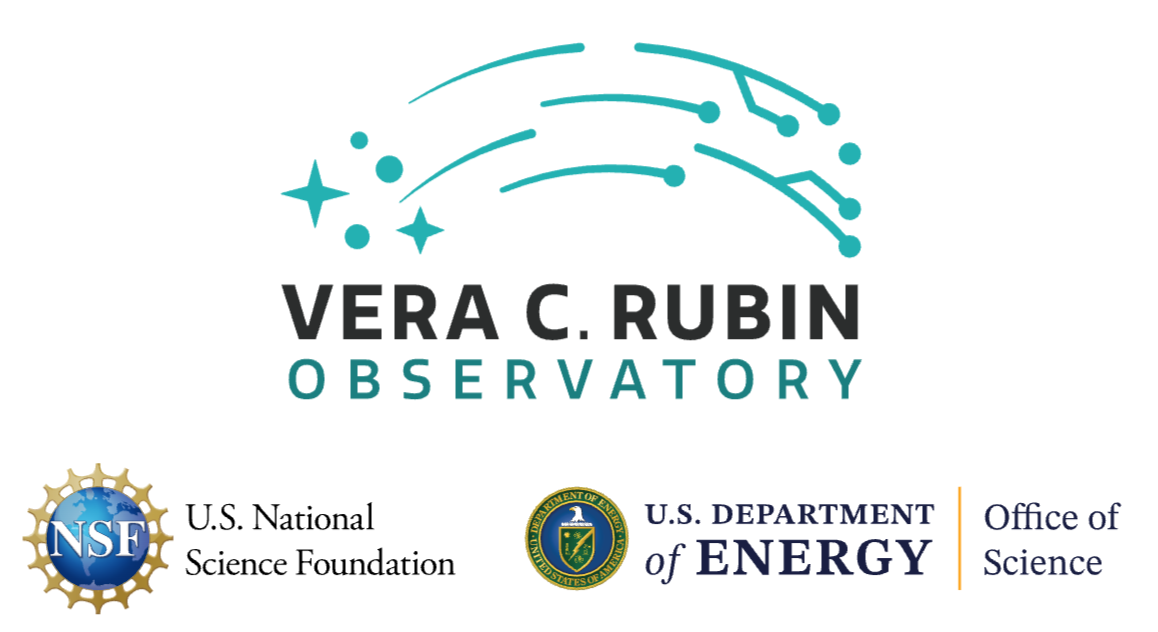
</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.1.1 <br>
Last verified to run: 2025-08-13 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** How to make a color image.

**LSST data products:** 

**Packages:** 

**Credit:** Originally developed by Andrés A. Plazas Malagón, Nate Lust, Clare Higgs, and the Rubin Community Science team.
Section 2 is based on a script by Nate Lust. 
Section 3 is based on a notebook by Phil Marshall, Phil Holloway, Ralf Kaehler, Ferro Shao, including code from Robert Lupton. 
Section 4 is based on a notebook by Céline Combet. 

Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Related tutorials:** See the 100-level series on image display.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This tutorial demonstrates how to use the [`lsst.pipe.tasks.prettyPictureMaker`](https://github.com/lsst/pipe_tasks/tree/main/python/lsst/pipe/tasks/prettyPictureMaker) code from the LSST Science Pipelines to produce high-quality RGB composite images from multi-band data. The workflow follows the approach described in the [technical note DMTN-323](https://dmtn-323.lsst.io/), *Color Composite Image Creation with the LSST Science Pipelines*.

The notebook is organized into the following sections:

1. **Introduction** 
2. **Configuration** – Building and explaining the `PrettyPictureTask` configuration object that controls image stretching, tone mapping, color balance, and other visual aspects.
3. **Euclid strong lens cutout** – Making a cutout of a strong lens candidate in the Euclid Deep Field South (DP1 field) and rendering it as a color composite.
4. **Galaxy cluster example** – Displaying a color composite of the galaxy cluster Abell 360.

### 1.1. Import packages

Import the `Butler` and `Timespan` modules from the `lsst.daf.butler` package, and the `display` module from the `lsst.afw` package (for image display).
Also import the `Time` function from the `astropy.time` module. 

In [1]:
from lsst.daf.butler import Butler
from lsst.afw.geom import makeSkyWcs
import lsst.geom as geom

from lsst.pipe.tasks.prettyPictureMaker import PrettyPictureTask
from lsst.pipe.tasks.prettyPictureMaker._task import ChannelRGBConfig

from lsst.ip.diffim import GetTemplateTask
from lsst.afw.image import Image
from lsst.afw.image import Exposure

import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS

### 1.2. Define parameters and functions

**Function**: `pretty_RGB` 

Creates and plots an RGB composite from g/r/i inputs using the `PrettyPictureTask` pipe task.

In [2]:
def pretty_RGB(images, config, ax=None, figsize=(8, 8), name=None):
    """Display an RGB (i–r–g) color composite image using PrettyPictureTask.

    This helper accepts either LSST `afw` Exposure objects (e.g., `ExposureF`)
    or NumPy arrays for each band and routes to the appropriate
    `PrettyPictureTask.makeInputsFrom*` constructor.

    Parameters
    ----------
    images : dict
        Dictionary with keys 'g', 'r', 'i' and values that are either:
        - `lsst.afw.image.Exposure` (e.g., `ExposureF`) for each band, or
        - `numpy.ndarray` for each band (same shape and alignment).
    config : PrettyPictureTask.ConfigClass
        Configuration object for `PrettyPictureTask`.
    ax : matplotlib.axes.Axes, optional
        Axis to draw on; if None, a new Figure and Axes are created.
    figsize : tuple, optional
        Size of the created `matplotlib.Figure` (ignored if `ax` is provided).
    name : str, optional
        Label to annotate the image.
    """
    for b in ("g", "r", "i"):
        if b not in images:
            raise KeyError(f"Missing '{b}' band in images dict.")

    g = images["g"]
    r = images["r"]
    i = images["i"]

    all_exposures = all(
        isinstance(band, Exposure) for band in (g, r, i)
    )
    all_arrays = all(
        isinstance(band, np.ndarray) for band in (g, r, i)
    )

    if not (all_exposures or all_arrays):
        raise TypeError(
            "All inputs must be the same type: either afw Exposure (e.g., ExposureF) "
            "or numpy.ndarray for every band."
        )

    task = PrettyPictureTask(config=config)

    if all_exposures:
        inputs = task.makeInputsFromExposures(i=i, r=r, g=g)
    else:  # all_arrays
        inputs = task.makeInputsFromArrays(i=i, r=r, g=g)

    rgb_struct = task.run(inputs)
    rgb = rgb_struct.outputRGB

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)

    ax.imshow(rgb, interpolation="nearest", origin="lower")
    ax.axis("off")

    if name:
        ax.text(0, 0.95, name, color="white", fontsize=12,
                ha="left", va="top", transform=ax.transAxes)

    return

**Function:** `make_target_wcs`

Builds a `lsst.afw.geom.SkyWcs` for a mosaic centered on the chosen coordinates, using an anchor image’s pixel scale and orientation.

In [3]:
def make_target_wcs(anchor_image, ra_deg, dec_deg, box_size_deg):
    """Build a target SkyWcs centered at (ra_deg, dec_deg) with scale taken
    from the anchor image and a reference pixel sized to cover the requested box.

    Parameters
    ----------
    anchor_image : `lsst.afw.image.Exposure`
        Exposure providing the reference WCS/scale (CD matrix).
    ra_deg, dec_deg : float
        Target center in ICRS degrees.
    box_size_deg : float
        Half-size of the square cutout in degrees (i.e., box extends ±box_size_deg).

    Returns
    -------
    newWCS : `lsst.afe.geom.SkyWcs`
        SkyWcs describing the target mosaic geometry.
    """
    crval = geom.SpherePoint(ra_deg, dec_deg, geom.degrees)
    pixel_scale = anchor_image.getWcs().getPixelScale().asArcseconds()
    crpix_val = box_size_deg * 3600 / pixel_scale
    crpix = geom.Point2D(crpix_val, crpix_val)
    md = anchor_image.getWcs().getFitsMetadata()
    cdMatrix = [[md["CD1_1"], md["CD1_2"]], [md["CD2_1"], md["CD2_2"]]]

    return makeSkyWcs(crpix, crval, cdMatrix, projection)

**Function:** `bbox_from_corners`

Converts sky-region corners into a pixel-space bounding box for a mosaic of images.

In [4]:
def bbox_from_corners(newWCS, corners):
    """Compute an integer pixel bounding box in the target WCS that encloses
    the requested sky rectangle defined by corner coordinates.

    Parameters
    ----------
    newWCS : `lsst.afw.geom.SkyWcs`
        WCS of the target mosaic/image.
    corners : `np.array`
        Iterable of corner (ra_deg, dec_deg) pairs; expects at least the
        south–east corner at index 0 and the north–west corner at index 2.

    Returns
    -------
    bbox : `lsst.geom.Box2I`
        Integer bounding box in pixel coordinates covering the sky rectangle.
    """
    corner_SE_deg = geom.SpherePoint(corners[0][0], corners[0][1], geom.degrees)
    corner_NW_deg = geom.SpherePoint(corners[2][0], corners[2][1], geom.degrees)
    corner_SE_pix = newWCS.skyToPixel(corner_SE_deg)
    corner_NW_pix = newWCS.skyToPixel(corner_NW_deg)
    xmin, ymin = map(int, np.floor([corner_SE_pix[0], corner_SE_pix[1]]))
    xmax, ymax = map(int, np.floor([corner_NW_pix[0], corner_NW_pix[1]]))
    newimg_shape = Image(
        geom.Box2I(
            minimum=geom.Point2I(x=xmin, y=ymin),
            maximum=geom.Point2I(x=xmax, y=ymax),
        ),
        dtype=np.float32,
    )
    return newimg_shape.getBBox()

Create an instance of the butler, and assert that it exists.

In [5]:
butler = Butler("dp1", collections="LSSTComCam/DP1")
assert butler is not None

## 2. Configuration

Define the configuration file for `PrettyPictureTask`, and set some parameters.

In [6]:
pretty_pic_config = PrettyPictureTask.ConfigClass()

### 2.1 `localContrastConfig.doLocalContrast`

This parameter toggles local-contrast enhancement in the luminance channel. It defaults to `True`; turn it off for small images or faster processing, and keep it on to boost mid-scale detail in extended objects (e.g., subtle spiral arms). When enabled, contrast is enhanced before color mapping, revealing structures that are close in brightness to their surroundings.

In [7]:
pretty_pic_config.localContrastConfig.doLocalContrast = False

### 2.2 `imageRemappingConfig.absMax`

This parameter sets the input data value (for Rubin data, in nJy) that will be treated as "white" in the output image.

If left unset, the brightest pixel in the image might be used as the white point --- but this can be unstable due to rare, very bright pixels in the long tail of the brightness histogram.

In [8]:
pretty_pic_config.imageRemappingConfig.absMax = 11000

### 2.3 `luminanceConfig.stretch`

This parameter controls the strength of the arcsinh stretch applied to the luminance channel.
The arcsinh function compresses the dynamic range of the image while still preserving faint structures, making it well-suited for astronomical images where bright sources and faint details coexist. 

In [9]:
pretty_pic_config.luminanceConfig.stretch = 750

### 2.4 `luminanceConfig.Q`

This is the asinh softening parameter. It controls how rapidly the arcsinh function transitions from a linear regime for faint values to a logarithmic regime for bright values. Smaller values make the transition sharper; larger values make it smoother.

In [10]:
pretty_pic_config.luminanceConfig.Q = 0.7

### 2.5 `luminanceConfig.highlight`, `luminanceConfig.shadow`, `luminanceConfig.midtone`

These parameters control a tone-mapping function applied after the arcsinh stretch, similar to the highlight, shadow, and midtone sliders in many photo-editing applications.
They determine how the luminance values, now scaled to the 0–1 range, are mapped to the final display brightness.

The `highlight` value sets the luminance level that will be mapped to white, while `shadow` sets the level that will be mapped to black.
The `midtone` parameter defines the balance point between white and black, affecting the overall contrast and brightness perception of the image.
Adjusting these values allows fine-tuning of the tonal balance to emphasize particular brightness ranges without altering the color mapping.

In [11]:
pretty_pic_config.luminanceConfig.highlight = 0.905882
pretty_pic_config.luminanceConfig.shadow = 0.12
pretty_pic_config.luminanceConfig.midtone = 0.25

### 2.6 `doPSFDeconcovlve`

This parameter controls whether the image will undergo Point Spread Function (PSF) deconvolution as part of the processing. Due to a typo in the name, the parameter is spelled `doPSFDeconcovlve` in the code. Setting it to `False` disables PSF deconvolution, which can simplify and speed up the processing, especially for tutorial or exploratory work. When enabled, PSF deconvolution can sharpen features in the image by compensating for the blurring effects of the point-spread function, but it also increases computational complexity and may amplify noise in low signal-to-noise regions.

In [12]:
pretty_pic_config.doPSFDeconcovlve = False

### 2.7 `exposureBrackets`

This parameter enables the use of exposure bracketing, an advanced technique for further compressing the dynamic range of an image. Exposure brackets combine differently scaled versions of the same image to retain detail in both the brightest and faintest regions, similar to high dynamic range (HDR) processing in photography. While powerful, this feature can require careful tuning to achieve the desired visual effect. For simplicity and consistency in this tutorial, it is set to `None`, which disables bracketing and uses a single stretch for the entire image.

In [13]:
pretty_pic_config.exposureBrackets = None

### 2.8 `colorConfig.maxChroma` and `colorConfig.saturation`

These parameters control how color intensity changes with brightness. Increasing `maxChroma` and `saturation` produces richer, more vibrant colors compared to the default settings, enhancing visual appeal while preserving the relative color balance of objects in the image.

In [14]:
pretty_pic_config.colorConfig.maxChroma = 80
pretty_pic_config.colorConfig.saturation = 0.6

### 2.9 `channelConfig`

This setting controls how each input band contributes to the red, green, and blue channels of the final RGB image. In the default configuration, the *g* band maps entirely to blue, the *r* band to green, and the *i* band to red, producing a straightforward g–r–i color composite. 

It's possible to assign any floating-point weights, allowing a band to contribute to multiple color channels. This can be used to fine-tune color balance or to include additional bands beyond three by mixing them into the RGB channels (e.g., adding *u* to blue and red to simulate violet, or mixing *z* into red). The mapping is applied uniformly across all brightness levels, so object colors remain consistent regardless of brightness. Keeping each band mapped to a single channel is simplest to interpret, but mixing can provide more flexibility and information.

In [15]:
pretty_pic_config.channelConfig = {}
pretty_pic_config.channelConfig["g"] = ChannelRGBConfig(r=0, g=0, b=1)
pretty_pic_config.channelConfig["r"] = ChannelRGBConfig(r=0, g=1, b=0)
pretty_pic_config.channelConfig["i"] = ChannelRGBConfig(r=1, g=0, b=0)

In [ ]:
pretty_pic_config.channelConfig = {}
pretty_pic_config.channelConfig["g"] = ChannelRGBConfig(r=0, g=0, b=1)
pretty_pic_config.channelConfig["r"] = ChannelRGBConfig(r=0, g=1, b=0)
pretty_pic_config.channelConfig["i"] = ChannelRGBConfig(r=1, g=0, b=0)

## 3. Euclid lens cutout

Make a cutout of a strong lens candidate from Euclid data in the Euclid Deep Field south DP1 field. 

Define the approximate coordinates of the lens, in degrees.
Coordinates from ["Euclid Quick Data Release (Q1): The Strong Lensing Discovery Engine"](https://doi.org/10.5281/zenodo.15025832).

In [21]:
ra_cen_euclid = 59.626134
dec_cen_euclid = -49.06175

Define the stamp size.

In [22]:
stamp_size = 32

Find the tract and patch that this target is in.

In [23]:
radec = geom.SpherePoint(ra_cen_euclid, dec_cen_euclid,
                         geom.degrees)
skymap = butler.get("skyMap")
tractInfo = skymap.findTract(radec)
patchInfo = tractInfo.findPatch(radec)

patch = tractInfo.getSequentialPatchIndex(patchInfo)
tract = tractInfo.getId()

In [24]:
print("tract: ", tract)
print("patch: ", patch)

tract:  2394
patch:  3


Define the bounding box for the image cutout.

In [25]:
xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
cutoutSize = geom.ExtentI(stamp_size, stamp_size)
bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
parameters = {'bbox': bbox}

Loop over all 'gri' bands and extract the `deep_couadd` cutout image in each one.

In [26]:
bands = ["g", "r", "i"]
cutout_dict = {}

for band in bands:
    dataId = {'tract': tract, 'patch': patch, 'band': band}
    cutout_dict[band] = butler.get("deep_coadd", parameters=parameters,
                                   dataId=dataId)

Plot the lens candidate. 

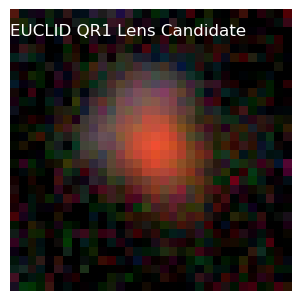

In [27]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 2)
pretty_RGB(cutout_dict, pretty_pic_config, ax=ax, name="EUCLID QR1 Lens Candidate")

## 4. Cluster Abell 360

Abell 360 (A360) is a rich galaxy cluster at redshift 0.22 that is included in the DP1 data release.
Create a color composite of the cluster to illustrate the use of `PrettyPictureTask` on a dense field of galaxies.

Define the coordinates of the brightest cluster galaxy (BCG), in degrees.

In [28]:
ra_bcg = 37.865
dec_bcg = 6.98

Define a box size of 0.1 degrees around the BCG, then search for all patches within twice that size (`2 * box_size_deg`).

In [29]:
box_size_deg = 0.1

Define the extent of the cutout in RA and Dec. Include the cos(dec) factor.

In [30]:
ra1 = ra_bcg + box_size_deg / np.cos(np.radians(dec_bcg))
ra2 = ra_bcg - box_size_deg / np.cos(np.radians(dec_bcg))
dec1 = dec_bcg - box_size_deg
dec2 = dec_bcg + box_size_deg
print('ra1 = %8.4f,  ra2 = %8.4f,  delta RA = %6.3f' %
      (ra1, ra2, np.abs(ra2-ra1)))
print('dec1 = %8.4f, dec2 = %8.4f, delta Dec = %6.3f' %
      (dec1, dec2, np.abs(dec2-dec1)))

ra1 =  37.9657,  ra2 =  37.7643,  delta RA =  0.201
dec1 =   6.8800, dec2 =   7.0800, delta Dec =  0.200


Define corners of the cutout.

The order is: SE, SW, NW, NE, as drawn in the plot below.

In [31]:
corners = np.asarray([[ra1, dec1], [ra2, dec1],
                      [ra2, dec2], [ra1, dec2]],
                     dtype='float')

### 4.1 Identify all the tracts and patches of interest.


In [32]:
radec = [geom.SpherePoint(ra, dec, geom.degrees)
         for ra, dec in [(ra2, dec1), (ra2, dec2), (ra1, dec1), (ra1, dec2)]]

tracts_and_patches = skymap.findTractPatchList(radec)

tp_dict = {
    tract_info.getId(): [p.sequential_index for p in patch_list]
    for tract_info, patch_list in tracts_and_patches
}

In [33]:
print(tp_dict)

{10463: [61, 71, 62, 72]}


### 4.2 Patch to use as anchor image

Define the tract and patch within which the central coordinates of the desired cutouts are most centered.

This will be the tract and patch referred to as the "anchor image" when creating the big cutout.

Define the patch that contains the BCG.

In [34]:
anchor_tract = 10463
anchor_patch = 61

Hold the tract and patch values for images that will contribute, in addition to the anchor image, to the final custom cutout in add_tracts_and_patches.

In [35]:
add_tracts_and_patches = np.array(
    [[t, p]
     for t, patches in tp_dict.items()
     for p in patches
     if (t, p) != (anchor_tract, anchor_patch)],
    dtype=int
)

print("Add these to the anchor patch:")
print(add_tracts_and_patches)

Add these to the anchor patch:
[[10463    71]
 [10463    62]
 [10463    72]]


### 4.3 Create the custom cutout, for the coadds in `g`, `r` and `i`.

Loop over the 3 bands (`g`,`r`, and `i`), and create a large mosaic cutout of each coadd.

In [36]:
getTemplateTask = GetTemplateTask()
sky_map = butler.get("skyMap")
projection = "TAN"

coadds = {}
for band in ("g", "r", "i"):

    anchor_dataId = {"tract": anchor_tract, "patch": anchor_patch, "band": band}
    anchor_image = butler.get("deep_coadd", dataId=anchor_dataId)

    neighbor_ids = [{"tract": int(t), "patch": int(p), "band": band}
                    for t, p in add_tracts_and_patches]
    all_dataIds = [anchor_dataId, *neighbor_ids]

    newWCS = make_target_wcs(anchor_image, ra_bcg, dec_bcg, box_size_deg)
    newimage_bbox = bbox_from_corners(newWCS, corners)

    dataset_refs = {
        ref
        for d in all_dataIds
        for ref in butler.query_datasets("deep_coadd", data_id=d)
    }
    handles = [butler.getDeferred(ref) for ref in dataset_refs]

    print(f"{band}-band: collecting patches/tracts overlapping the target bbox")
    results = getTemplateTask.getExposures(handles, newimage_bbox, sky_map, newWCS)

    newimage = getTemplateTask.run(
        coaddExposures=results.coaddExposures,
        bbox=newimage_bbox,
        wcs=newWCS,
        dataIds=results.dataIds,
        physical_filter=band,
    )
    coadds[band] = newimage.template

g-band: collecting patches/tracts overlapping the target bbox


r-band: collecting patches/tracts overlapping the target bbox


i-band: collecting patches/tracts overlapping the target bbox


Plot the cluster.

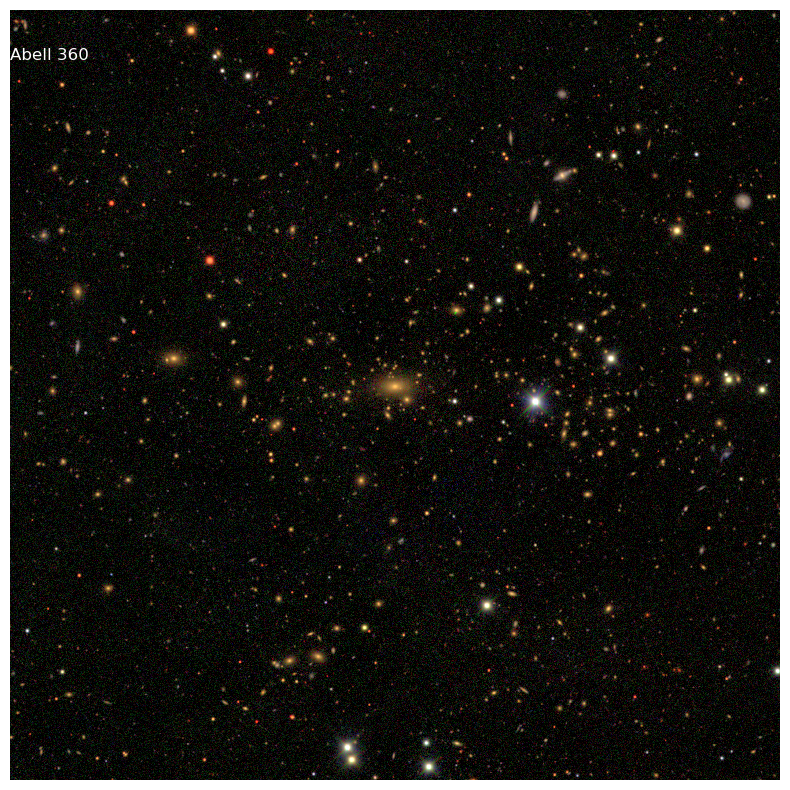

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10),
                       subplot_kw={'projection': WCS(coadds['g'].getWcs().getFitsMetadata())})

pretty_RGB(coadds, pretty_pic_config, ax=ax, name="Abell 360")